# The Variational Quantum Linear Solver

In [1]:
from qiskit import QuantumCircuit
import numpy as np
from typing import List
import sys
sys.path.append("..")

from Code.VQLS.Circuits import getSolutionVector, specialHadamardTest,hadamardTest
from Code.VQLS.NormEstimation import estimateNorm
from Code.VQLS.Ansatz import fixedAnsatz, controlledFixedAnsatz
from Code.VQLS.LCU import convertMatrixIntoCircuit, getLCU
from Code.VQLS.LabelVector import labelVectorCircuit,controlledLabelVectorCircuit, getPaddedLabelVector
from Code.VQLS.Minimization import minimization, getApproximationValue, plotCost
from Code.Utils import createMatrixFromParameters, generateParams, appendMatrices

In [2]:
qubits = 3 # 3
iterations = 2000
layers = 3
shots: int = 10000

## 1. Introduction

The Variational Quantum Linear Solver, or the VQLS is a variational quantum algorithm that utilizes VQE in order to solve systems of linear equations more efficiently than classical computational algorithms. Specifically, if we are given some matrix $\textbf{A}$, such that $\textbf{A} |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, where $|\textbf{b}\rangle$ is some known vector, the VQLS algorithm is theoretically able to find a normalized $|x\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.

The output of this algorithm is identical to that of the HHL Quantum Linear-Solving Algorithm, except, while HHL provides a much more favourable computation speedup over VQLS, the variational nature of our algorithm allows for it to be performed on NISQ quantum computers, while HHL would require much more robust quantum hardware, and many more qubits.


## 2. The Algorithm

To begin, the inputs into this algorithm are evidently the matrix $\textbf{A}$, which we have to decompose into a linear combination of unitaries with complex coefficients:



$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$



Where each $A_n$ is some unitary, and some unitary $U$ that prepares state $|\textbf{b}\rangle$ from $|0\rangle$. Now, recall the general structure of a variational quantum algorithm. We have to construct a quantum cost function, which can be evaluated with a low-depth parameterized quantum circuit, then output to the classical optimizer. This allows us to search a parameter space for some set of parameters $\alpha$, such that $|\psi(\alpha)\rangle \ = \ \frac{|\textbf{x}\rangle}{|| \textbf{x} ||}$, where $|\psi(k)\rangle$ is the output of out quantum circuit corresponding to some parameter set $k$.

Before we actually begin constructing the cost function, let's take a look at a "high level" overview of the sub-routines within this algorithm, as illustrated in this image from the original paper:

![alt text](images/bro.png)

So essentially, we start off with a qubit register, with each qubit initialized to $|0\rangle$. Our algorithm takes its inputs, then prepares and evaluates the cost function, starting with the creation of some ansatz $V(\alpha)$. If the computed cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates, and the ansatz is calculated with the optimal parameters (determined at termination). This gives us the state vector that minimizes our cost function, and therefore the normalized form of $|\textbf{x}\rangle$.

## 3. Qiskit Implementation

### Fixed Hardware Ansatz
Let's start off by considering the ansatz $V(\alpha)$, which is just a circuit that prepares some arbitrary state $|\psi(k)\rangle$. This allows us to "search" the state space by varying some set of parameters, $k$. Anyways, the ansatz that we will use for this implementation is given as follows:

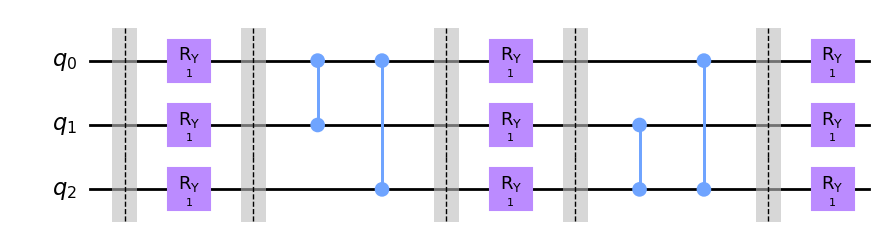

In [3]:
circ: QuantumCircuit = QuantumCircuit(qubits)
params = generateParams(qubits,layers)
fixedAnsatz(circ, qubits, params,layers=layers, barrier=True)
circ.draw(output="mpl", style="clifford")

This is called a **fixed hardware ansatz**: the configuration of quantum gates remains the same for each run of the circuit, all that changes are the parameters. Unlike the QAOA ansatz, it is not composed solely of Trotterized Hamiltonians. The applications of $Ry$ gates allow us to search the state space, while the $CZ$ gates create "interference" between the different qubit states. 

Now, it makes sense for us to consider the actual **cost function**. The goal of our algorithm will be to minimize cost, so when $|\Phi\rangle \ = \ \textbf{A} |\psi(k)\rangle$ is very close to $|\textbf{b}\rangle$, we want our cost function's output to be very small, and when the vectors are close to being orthogonal, we want the cost function to be very large. Thus, we introduce the "projection" Hamiltonian:



$$H_P \ = \ \mathbb{I} \ - \ |b\rangle \langle b|$$



Where we have:



$$C_P \ = \ \langle \Phi | H_P | \Phi \rangle \ = \ \langle \Phi | (\mathbb{I} \ - \ |b\rangle \langle b|) |\Phi \rangle \ = \ \langle \Phi | \Phi \rangle \ - \ \langle \Phi |b\rangle \langle b | \Phi \rangle$$



Notice how the second term tells us "how much" of $|\Phi\rangle$ lies along $|b\rangle$. We then subtract this from another number to get the desired low number when the inner product of $|\Phi\rangle$ and $|b\rangle$ is greater (they agree more), and the opposite for when they are close to being orthogonal. This is looking good so far! However, there is still one more thing we can do to increase the accuracy of the algorithm: normalizing the cost function. This is due to the fact that if $|\Phi\rangle$ has a small norm, then the cost function will still be low, even if it does not agree with $|\textbf{b}\rangle$. Thus, we replace $|\Phi\rangle$ with $\frac{|\Phi\rangle}{\sqrt{\langle \Phi | \Phi \rangle}}$:



$$\hat{C}_P \ = \ \frac{\langle \Phi | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{\langle \Phi |b\rangle \langle b | \Phi \rangle}{\langle \Phi | \Phi \rangle} \ = \ 1 \ - \ \frac{|\langle b | \Phi \rangle|^2}{\langle \Phi | \Phi \rangle}$$



Ok, so, we have prepared our state $|\psi(k)\rangle$ with the ansatz. Now, we have two values to calculate in order to evaluate the cost function, namely $|\langle b | \Phi \rangle|^2$ and $\langle \Phi | \Phi \rangle$. Luckily, a nifty little quantum subroutine called the **Hadamard Test** allows us to do this! Essentially, if we have some unitary $U$ and some state $|\phi\rangle$, and we want to find the expectation value of $U$ with respect to the state, $\langle \phi | U | \phi \rangle$, then we can evaluate the following circuit:

<br><br>

![image1](images/h.png)

<br><br>

Then, the probability of measuring the first qubit to be $0$ is equal to $\frac{1}{2} (1 \ + \ \text{Re}\langle U \rangle)$ and the probability of measuring $1$ is $\frac{1}{2} (1 \ - \ \text{Re}\langle U \rangle)$, so subtracting the two probabilities gives us $\text{Re} \langle U \rangle$. Luckily, the matrices we will be dealing with when we test this algorithm are completely real, so $\text{Re} \langle U \rangle \ = \ \langle U \rangle$, for this specific implementation. Here is how the Hadamard test works. By the circuit diagram, we have as our general state vector:

<br>



$$\frac{|0\rangle \ + \ |1\rangle}{\sqrt{2}} \ \otimes \ |\psi\rangle \ = \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}}$$



<br>

Applying our controlled unitary:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}}$$



<br>

Then applying the Hadamard gate to the first qubit:

<br>



$$\frac{|0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ U|\psi\rangle}{\sqrt{2}} \ \rightarrow \ \frac{1}{2} \ \big[ |0\rangle \ \otimes \ |\psi\rangle \ + \ |1\rangle \ \otimes \ |\psi\rangle \ + \ |0\rangle \ \otimes \ U|\psi\rangle \ - \ |1\rangle \ \otimes \ U|\psi\rangle \big]$$



<br>



$$\Rightarrow \ \frac{1}{2} |0\rangle \ \otimes \ (\mathbb{I} \ + \ U)|\psi\rangle \ + \ \frac{1}{2} |1\rangle \ \otimes \ (\mathbb{I} \ - \ U)|\psi\rangle$$



<br>

When we take a measurement of the first qubit, remember that in order to find the probability of measuring $0$, we must take the inner product of the state vector with $|0\rangle$, then multiply by its complex conjugate (see the quantum mechanics section if you are not familiar with this). The same follows for the probability of measuring $1$. Thus, we have:

<br>



$$P(0) \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I} \ + \ U) (\mathbb{I} \ + \ U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (\mathbb{I}^2 \ + U \ + \ U^{\dagger} \ + U U^{\dagger}) |\psi\rangle \ = \ \frac{1}{4} \ \langle \psi | (2\mathbb{I} \ + U \ + \ U^{\dagger}) |\psi\rangle$$



<br>



$$\Rightarrow \ \frac{1}{4} \Big[ 2 \ + \ \langle \psi | U^{\dagger} | \psi \rangle \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{4} \Big[ 2 \ + \ (\langle \psi | U | \psi \rangle)^{*} \ + \ \langle \psi | U | \psi \rangle \Big] \ = \ \frac{1}{2} (1 \ + \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

By a similar procedure, we get:

<br>



$$P(1) \ = \ \frac{1}{2} \ (1 \ - \ \text{Re} \ \langle \psi | U | \psi \rangle)$$



<br>

And so, by taking the difference:

<br>



$$P(0) \ - \ P(1) \ = \ \text{Re} \ \langle \psi | U | \psi \rangle$$



<br>

Cool! Now, we can actually implement this for the two values we have to compute. Starting with $\langle \Phi | \Phi \rangle$, we have:

<br>



$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$



<br>

and so our task becomes computing every possible term $\langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$ using the Hadamard test. This requires us to prepare the state $V(k) |0\rangle$, and then perform controlled operations with some control-auxiliary qubits for the unitary matrices $A_m^{\dagger}$ and $A_n$. We can implement this in code:


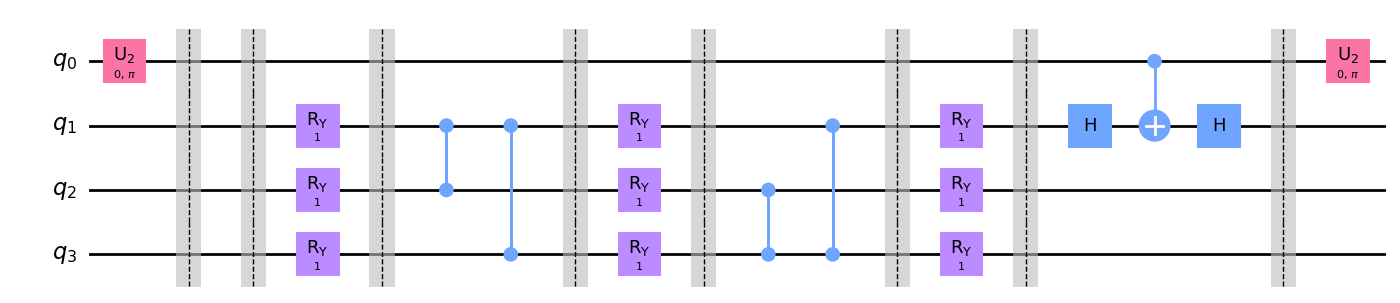

In [4]:
circ: QuantumCircuit = QuantumCircuit(qubits+1)
matrices = ["ZII"]
matrices = appendMatrices(matrices, qubits)
matrix: np.ndarray  = createMatrixFromParameters([1], matrices)
paulis, coefficientSet = getLCU(matrix)
params = generateParams(qubits, layers=layers)

fixedAnsatzCircuit = QuantumCircuit(qubits+1)
fixedAnsatz(fixedAnsatzCircuit, qubits, params,layers=layers, barrier=True,offset=1)


hadamardTest(circ,paulis, fixedAnsatzCircuit)
circ.draw(output="mpl", style="clifford")
circ.decompose().draw(output="mpl", style="clifford")

The reason why we are applying two different "gate_types" is because this represents the pairs of gates shown in the expanded form of $\langle \Phi | \Phi \rangle$.

It is also important to note that for the purposes of this implementation (the systems of equations we will actually be solving, we are only concerned with the gates $Z$ and $\mathbb{I}$, so I only include support for these gates (The code includes number "identifiers" that signify the application of different gates, $0$ for $\mathbb{I}$ and $1$ for $Z$).

Now, we can move on to the second value we must calculate, which is $|\langle b | \Phi \rangle|^2$. We get:

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ |\langle b | A V(k) | 0 \rangle|^2 \ = \ |\langle 0 | U^{\dagger} A V(k) | 0 \rangle|^2 \ = \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

All we have to do now is the same expansion as before for the product $\langle 0 | U^{\dagger} A V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$:

<br>



$$\langle 0 | U^{\dagger} A V(k) | 0 \rangle^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | V(k)^{\dagger} A_m^{\dagger} U |0\rangle$$



<br>

Now, again, for the purposes of this demonstration, we will soon see that all the outputs/expectation values of our implementation will be real, so we have:
<br>



$$\Rightarrow \ \langle 0 | U^{\dagger} A V(k) | 0 \rangle \ = \ (\langle 0 | U^{\dagger} A V(k) | 0 \rangle)^{*} \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} U |0\rangle$$



<br>

Thus, in this particular implementation:

<br>



$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$



<br>

There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test** (see cited paper), but for this tutorial, we will just be using a standard Hadamard Test, where we control each matrix. This unfortunately requires the use of an extra auxiliary qubit. We essentially just place a control on each of the gates involved in the auxiliary, the $|b\rangle$ preparation unitary, and the $A_n$ unitaries. We get something like this for the controlled-ansatz:


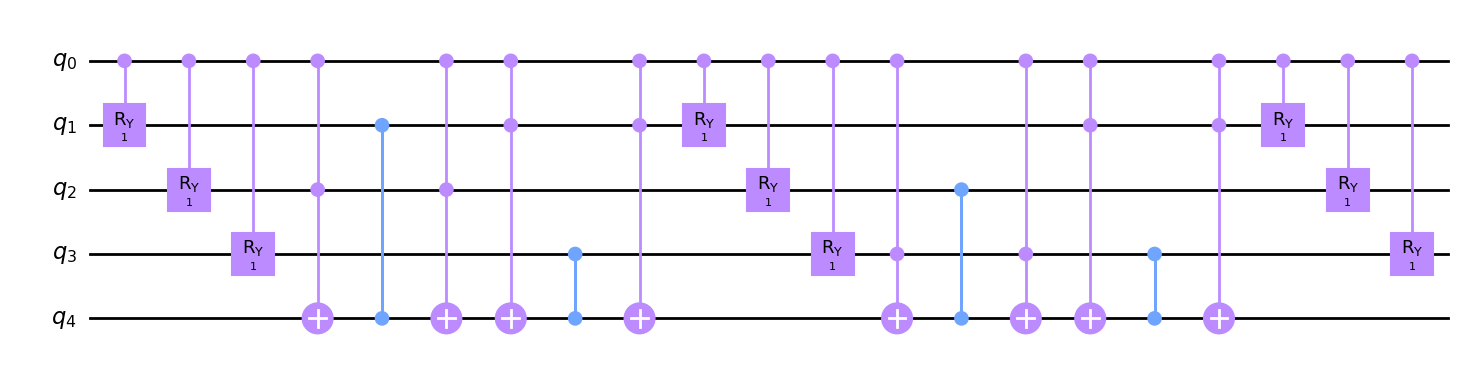

In [5]:
circ: QuantumCircuit = QuantumCircuit(qubits+2)
params = generateParams(qubits, layers)
controlledFixedAnsatz(circ, qubits, params)
circ.draw(output="mpl", style="clifford")

Notice the extra qubit, `q0_4`. This is an auxiliary, and allows us to create a $CCZ$ gate, as is shown in the circuit. Now, we also have to create the circuit for $U$. In our implementation, we will pick $U$ as:

<br>



In this function we encode the vector with the amplitude encoding:



<br>

Thus, we have:

[0.57735027 0.57735027 0.57735027 0.        ]


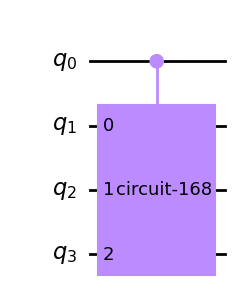

In [6]:
print(getPaddedLabelVector([1, 1, 1]))

circ: QuantumCircuit = labelVectorCircuit([1, 1, 1])
circ.draw(output="mpl", style="clifford")

circ: QuantumCircuit = QuantumCircuit(qubits+1)
controlledLabelVectorCircuit(circ, 0, qubits, [1 for _ in range(2**qubits)])
circ.draw(output="mpl", style="clifford")

# Matrix decomposition and gate creation

We use sparseMatrixOP to get the linear combination of unitary matrices with their coeffitiens.

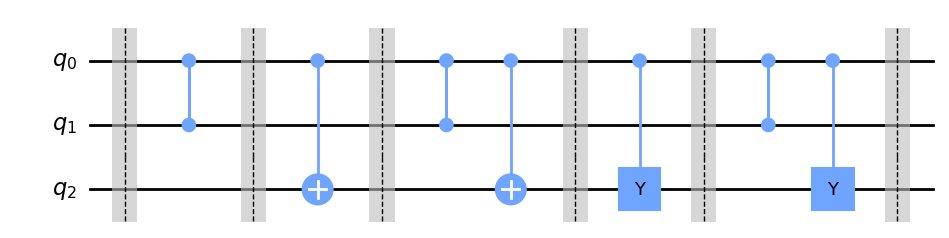

In [7]:
A: np.ndarray = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, 3, 0, 0]])
paulis, coefficientSet = getLCU(A)
circ: QuantumCircuit = QuantumCircuit(len(paulis[0])+1)
convertMatrixIntoCircuit(circ, paulis, controlled=True, auxiliaryQubit=0)
circ.draw(output="mpl", style="clifford")

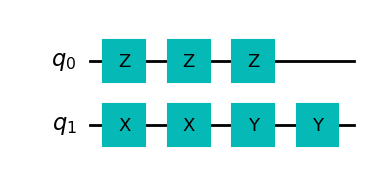

In [8]:
A: np.ndarray = np.array([[1, 0, 0, 0],
              [0, 0, 0, 1],
              [0, 0, 1, 0],
              [0, 3, 0, 0]])

paulis, coefficientSet = getLCU(A)
circ: QuantumCircuit = QuantumCircuit(len(paulis[0]))
convertMatrixIntoCircuit(circ, paulis,showBarriers=False)
circ.draw(output="mpl", style="clifford")

Finally, we construct our new Hadamard test:

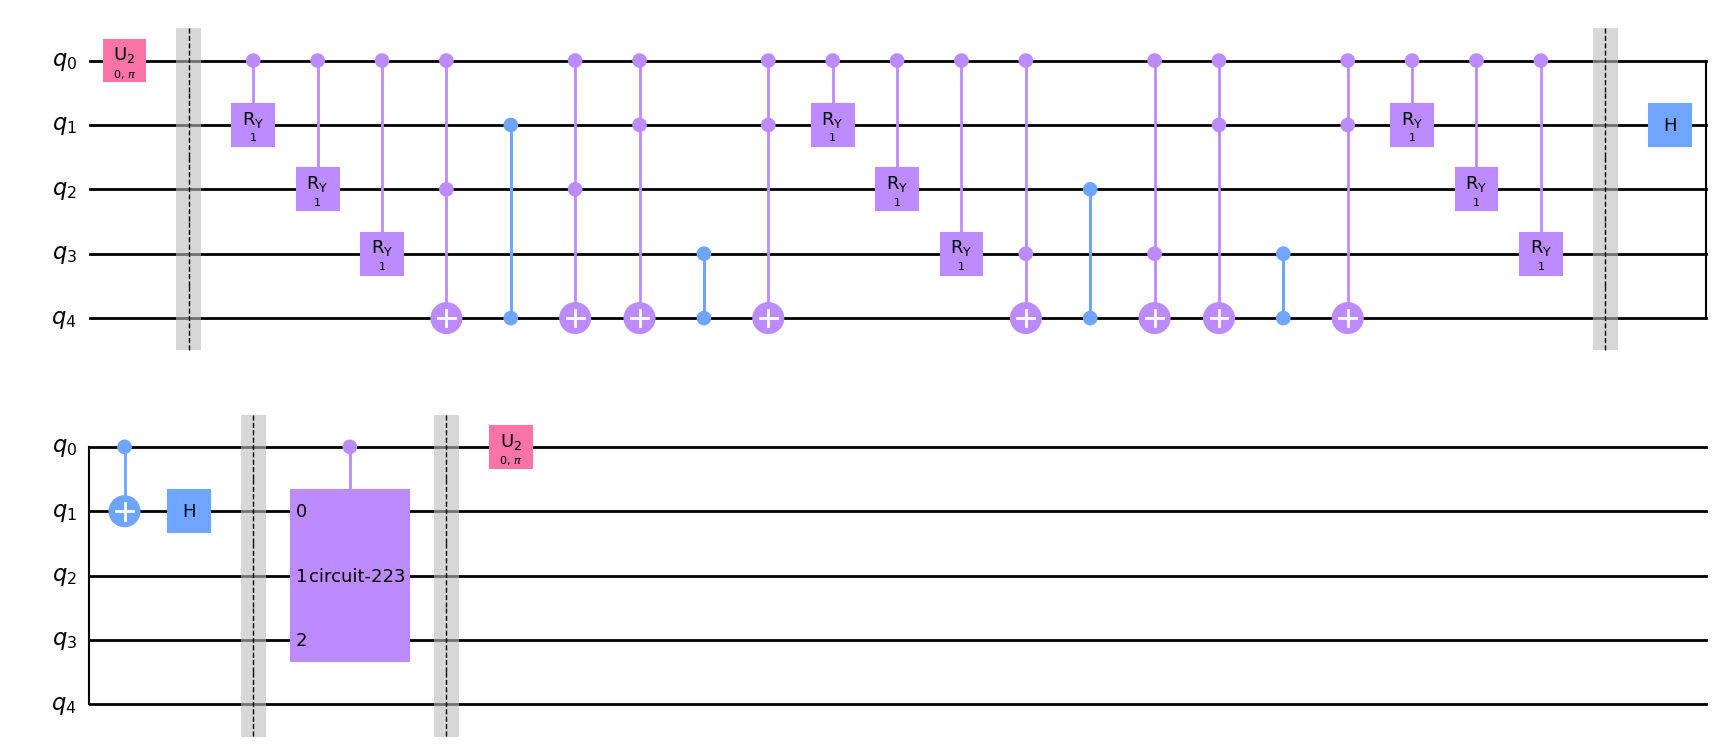

In [9]:
matrices = ["ZII"]
matrices = appendMatrices(matrices, qubits)
matrix: np.ndarray = createMatrixFromParameters([1], matrices)
circ: QuantumCircuit = QuantumCircuit(qubits+2)
paulis, _ = getLCU(matrix)
params = generateParams(qubits, layers=layers)

labelVectorCircuit = QuantumCircuit(qubits + 1)
controlledLabelVectorCircuit(labelVectorCircuit, 0, qubits, [1 for _ in range(2**qubits)])

controlledFixedAnsatzCircuit = QuantumCircuit(qubits + 2)
controlledFixedAnsatz(
    controlledFixedAnsatzCircuit, qubits, params
)

specialHadamardTest(
    circ,
    paulis,
    controlledFixedAnsatzCircuit,
    labelVectorCircuit
)
circ.draw(output="mpl", style="clifford")
circ.decompose().draw(output="mpl", style="clifford")

The final step is to actually use this code to solve a real linear system. We will first be looking at the example:

<br>



$$A \ = \ 0.45 Z_3 \ + \ 0.55 \mathbb{I}$$



<br>

In order to minimize the cost function, we use the COBYLA optimizer method, which we repeatedly applying. Our search space for parameters is determined by $\frac{k}{1000} \ k \ \in \ \{0, \ 3000\}$, which is initially chosen randomly. We will run the optimizer for $200$ steps, then terminate and apply the ansatz for our optimal parameters, to get our optimized state vector! In addition, we will compute some post-processing, to see if our algorithm actually works! In order to do this, we will apply $A$ to our optimal vector $|\psi\rangle_o$, normalize it, then calculate the inner product squared of this vector and the solution vector, $|b\rangle$! We can put this all into code as:

Time to prepare circuits: 0.2998619079589844
Time to minimize: 6.012039899826051411386e-065
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 8.367263886754905e-06
       x: [ 3.438e-03  8.142e-01  1.581e+00  1.738e+00  1.422e+00
            1.559e+00 -1.204e+00  6.648e-01  1.563e+00]
    nfev: 1750
   maxcv: 0.0
Statevector([-0.04979889+0.j,  0.49655223+0.j,  0.04970339+0.j,
             -0.49492918+0.j,  0.04973171+0.j, -0.4983608 +0.j,
             -0.04982287+0.j,  0.50021154+0.j],
            dims=(2, 2, 2))
[-0.04979889+0.j  0.04965522+0.j  0.04970339+0.j -0.04949292+0.j
  0.04973171+0.j -0.04983608+0.j -0.04982287+0.j  0.05002115+0.j]
[-0.35384399+0.j  0.35282321+0.j  0.35316548+0.j -0.35166995+0.j
  0.3533667 +0.j -0.35410827+0.j -0.35401438+0.j  0.35542331+0.j]
1.6305131056942352e-07


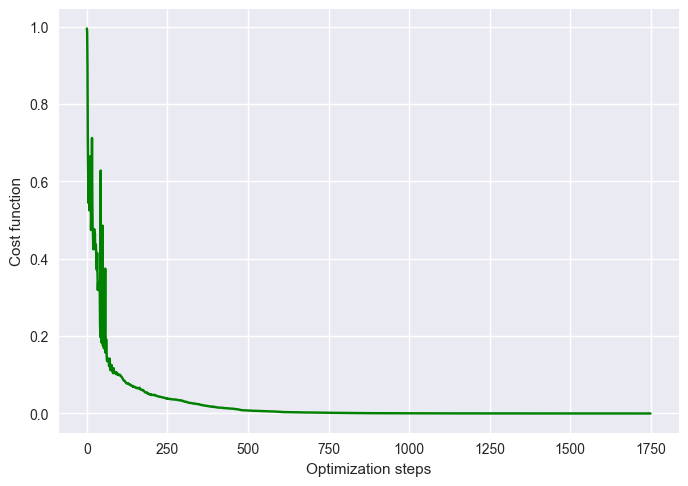

In [10]:
b = [1 for _ in range(2**qubits)]

bVector: np.array = getPaddedLabelVector(b)
matrices = ["ZII", "III"]
matrices = appendMatrices(matrices,qubits)
A: np.ndarray = createMatrixFromParameters([0.45, 0.55], matrices)

paulis, coefficientSet = getLCU(A)

outF: List[List[float]] = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    qubits=qubits,
    bVector=bVector,
    quantumSimulation=False,
    method="COBYLA",
    iterations= iterations,
)
circ: QuantumCircuit = QuantumCircuit(qubits, qubits)
o: List[complex] = getSolutionVector(circ, qubits, outF)

print(o)
print(A.dot(o))
print((A.dot(o) / (np.linalg.norm(A.dot(o)))))
print(getApproximationValue(A, bVector, o))
plotCost()

In [11]:
estimatedNorm, estimatedNormVector = estimateNorm(A, o, bVector)

print (estimatedNorm)
print (list(estimatedNormVector*estimatedNorm))
x: np.array = np.linalg.solve(A, bVector)
print(x)
print (np.linalg.norm(x))

(7.105489755863321+0j)
[(0.3538454679314646+0j), (3.5282468140696936+0j), (0.3531669611619323+0j), (3.516714224052225+0j), (0.3533681815263286+0j), (3.541097552728908+0j), (0.3540158604180061+0j), (3.554247946233755+0j)]
[0.35355339+0.j 3.53553391+0.j 0.35355339+0.j 3.53553391+0.j
 0.35355339+0.j 3.53553391+0.j 0.35355339+0.j 3.53553391+0.j]
7.106335201775944


As you can see, our cost function has achieved a fairly low value of `0.03273673575407443`, and when we calculate our classical cost function, we get `0.96776862579723`, which agrees perfectly with what we measured, the vectors $|\psi\rangle_o$ and $|b\rangle$ are very similar!

Let's do another test! This time, we will keep $|b\rangle$ the same, but we will have:

<br>



$$A \ = \ 0.55 \mathbb{I} \ + \ 0.225 Z_2 \ + \ 0.225 Z_3$$



Again, we run our optimization code:

Time to prepare circuits: 0.31482505798339844
Time to minimize: 17.3866207599639983427e-0505
2.763865693356017e-08


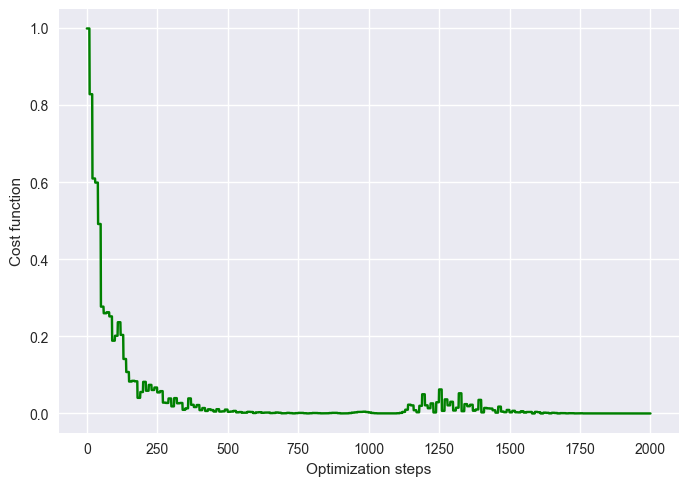

In [12]:
b = [1 for _ in range(2**qubits)]
# b = np.array([1, 1, 1, -1, 1, 1, 1, 1])
bVector: np.array = getPaddedLabelVector(b)
matrices = ["ZII", "IZI", "III"]
matrices = appendMatrices(matrices, qubits)
A: np.ndarray = createMatrixFromParameters([0.225, 0.225, 0.55], matrices)

paulis, coefficientSet = getLCU(A)

outF: List[List[float]] = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    qubits=qubits,
    bVector=bVector,
    quantumSimulation=False,
    method="ADAM",
    options={"lr": 0.35},
    # method="SPSA",
    # options={"learnin_rate": 0.35, "perturbation": 0.1},
    # method="GD",
    # options={"learnin_rate": 0.2},
)
circ: QuantumCircuit = QuantumCircuit(qubits, qubits)
o: List[complex] = getSolutionVector(circ,qubits, outF)

print(getApproximationValue(A, bVector, o))
plotCost()

In [13]:
estimatedNorm, estimatedNormVector = estimateNorm(A, o, bVector)

print (estimatedNorm)
print (list(estimatedNormVector*estimatedNorm))
x: np.array = np.linalg.solve(A, bVector)
print(x)
print (np.linalg.norm(x))

(5.154973293038249+0j)
[(0.3531595301168919+0j), (0.6463065638439112+0j), (0.6438362217707958+0j), (3.51436918414874+0j), (0.35357078099877726+0j), (0.6465666879202564+0j), (0.6440737258243313+0j), (3.5082913556803437+0j)]
[0.35355339+0.j 0.64282435+0.j 0.64282435+0.j 3.53553391+0.j
 0.35355339+0.j 0.64282435+0.j 0.64282435+0.j 3.53553391+0.j]
5.186799838241635



Again, very low error, and the classical cost function agrees! Great, so it works!


Let's try our sampling for our second value of $A$, with the same matrix $U$ and quantum simulation:


[[1.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.55+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.55+0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.1 +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 1.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.55+0.j 0.  +0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.55+0.j 0.  +0.j]
 [0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.  +0.j 0.1 +0.j]]
Time to prepare circuits: 0.31764912605285645
Time to minimize: 64.26769995689392321173
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.21810726406854597
       x: [ 3.052e-01  9.715e-01  1.081e+00  1.932e+00  1.633e+00
            1.533e+00 -2.793e-01  1.027e-01  4.661e-01]
    nfev: 92
   maxcv: 0.0
0.0217426275332399


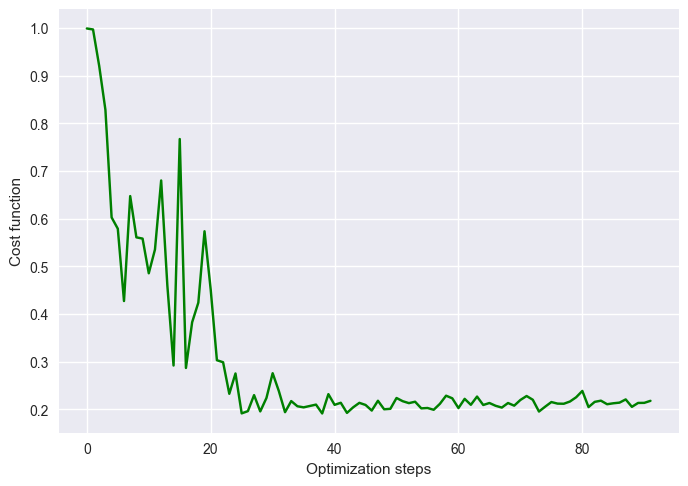

In [14]:
b = [1 * (-1)**(i) for i in range(2**qubits)]
# b = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1 ,1,1,1,1,1])
bVector: np.array = getPaddedLabelVector(b)
matrices = ["ZII", "IZI", "III"]
matrices = appendMatrices(matrices, qubits)
A: np.ndarray = createMatrixFromParameters([0.225, 0.225, 0.55], matrices)
print (A)

paulis, coefficientSet = getLCU(A)

outF: List[List[float]] = minimization(
    paulis=paulis,
    coefficientSet=coefficientSet,
    qubits=qubits,
    bVector=bVector,
    iterations= iterations,
)
circ: QuantumCircuit = QuantumCircuit(qubits, qubits)
o: List[complex] = getSolutionVector(circ,qubits, outF)

print(getApproximationValue(A, bVector, o))

plotCost()

In [15]:
estimatedNorm, estimatedNormVector = estimateNorm( A, o, bVector)

print (estimatedNorm)
print (list(estimatedNormVector*estimatedNorm))
x: np.array = np.linalg.solve(A, bVector)
print(x)
print (np.linalg.norm(x))

(3.451713241093999+0j)
[(0.2971124427371676+0j), (-0.6755571727649066+0j), (0.7529945388952871+0j), (-0.09837336242540538+0j), (0.302979184425896+0j), (-0.8436890633367736+0j), (1.2322093277470425+0j), (-2.910506048313799+0j)]
[ 0.35355339+0.j -0.64282435+0.j  0.64282435+0.j -3.53553391+0.j
  0.35355339+0.j -0.64282435+0.j  0.64282435+0.j -3.53553391+0.j]
5.186799838241635


In [58]:
import qiskit
from qiskit import Aer
from concurrent.futures import ThreadPoolExecutor
from math import pi
import time

def circuitTest(circ_list, parallel:bool,shots:int, workers = 2, jobSize = 1):
    backend = Aer.get_backend("aer_simulator")
    if parallel:
        exc = ThreadPoolExecutor(max_workers=workers)
        backend.set_options(executor=exc)
        backend.set_options(max_job_size=jobSize)
    
    totalTimes = 0
    for _ in range(5):
        start = time.time()
        backend.run(circ_list,shots = shots).result()
        end = time.time()
        totalTimes += end - start

    
    if parallel != True:
        print("parallel: ", parallel)
        print("Time taken: ", totalTimes/5)
    return totalTimes/5

In [61]:
from qiskit.compiler import transpile
circuits= 3000
shots = 1

circ_list = []
for _ in range(circuits):
    circ = qiskit.QuantumCircuit(15, 15)
    circ.h(0)
    circ.cx(0, 1)
    circ.cx(1, 2)
    circ.p(pi/2, 2)
    circ.measure([0, 1, 2], [0, 1 ,2])
    circ_list.append(circ)

circ_list = transpile(circ_list, backend = Aer.get_backend("aer_simulator"))
circuitTest(circ_list,False,shots)

print("worker sizes")

bestTime = time.time()
bestWorkers = 0
bestJobSize = 0
for i in range (0,2):#10
    for j in range (0,2):#10
        timeCirc = circuitTest(circ_list,True,shots,workers=2**i,jobSize=2**j)
        if timeCirc < bestTime:
            bestTime = timeCirc
            bestWorkers = 2**i
            bestJobSize = 2**j

print("best time: ", bestTime)
print ("best workers: ", bestWorkers)
print ("best job size: ", bestJobSize)


parallel:  False
Time taken:  0.5363733768463135
worker sizes
best time:  1.7478483200073243
best workers:  2
best job size:  2


So as you can see, not amazing, our solution is still off by a fairly significant margin ($~3\%$ error isn't awful, but ideally, we want it to be **much** closer to 0). Again, I think this is due to the optimizer itself, not the actual quantum circuit. I will be making an update to this Notebook once I figure out how to correct this problem (likely with the introduction of a noisy optimizer, as I previously mentioned).